# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [14]:
import torch
import torch.nn as nn

## I. Data

### Importing data

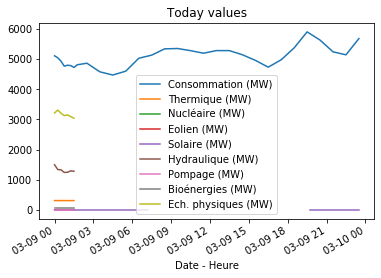

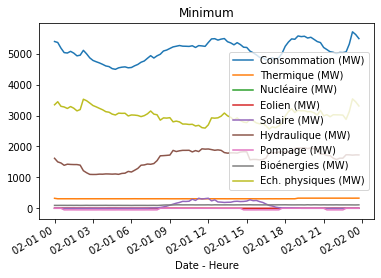

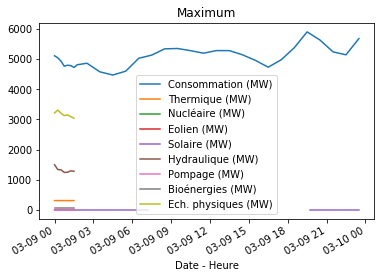

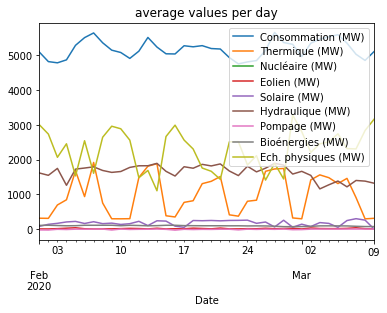

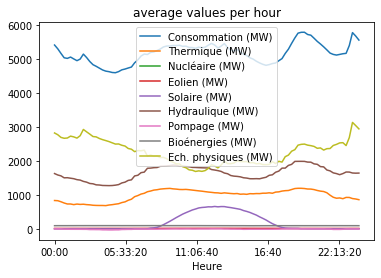

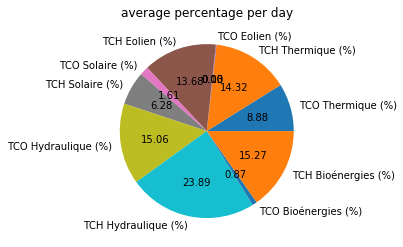

(115233, 81)
(29003, 18)
datetime64[ns, Europe/Paris]
datetime64[ns, Europe/Paris]
datetime64[ns]


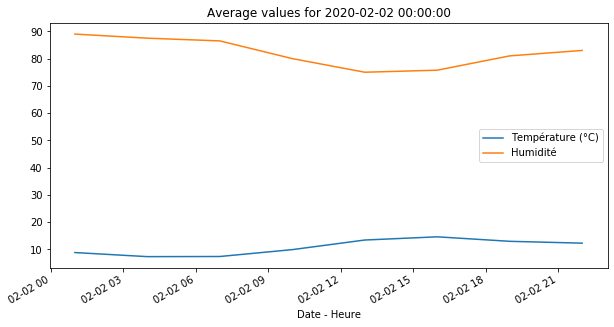

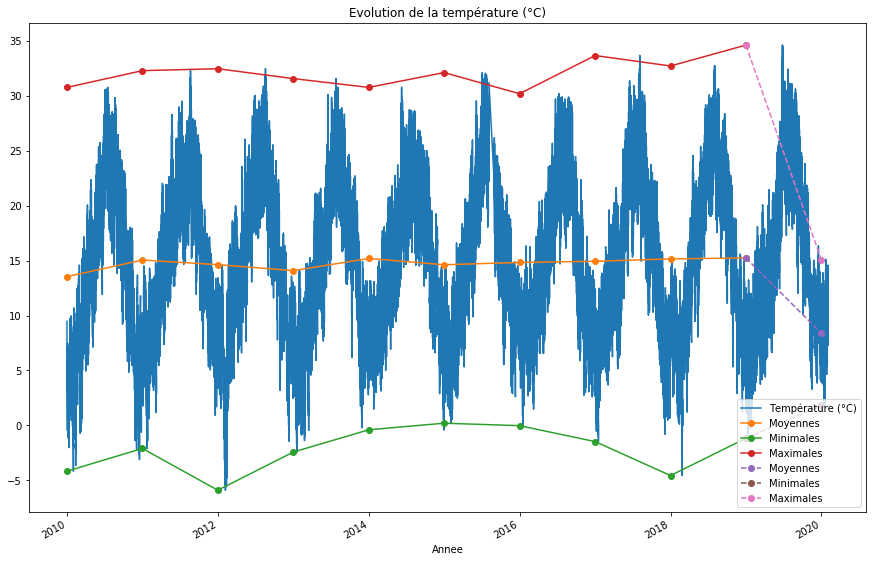

In [15]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

### Processing data

In [16]:
# checking date's format
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
print(data['Date'].dtypes == data_meteo['Date'].dtypes)

True
True


## II. Prediction

In [17]:
TRAIN_SPLIT = 240 # size of the training dataset
NB_DAYS = 10 # number of days to be predicted
BATCH_SIZE = 3

### Training dataset

In [18]:
data_train = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure']).drop(['Consommation (MW)'], axis=1)
print(data_train.shape)
data_train = data_train.fillna(0)
# final training dataset
data_train.head()

(16, 45)


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
0,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,01:00:00,2020-02-01 01:00:00+01:00,308.0,0.0,6.0,0.0,...,0.666667,98845.0,5.300,-10.0,0.000000,0.000000,0.000000,0.000000,4.00,9.250
1,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,04:00:00,2020-02-01 04:00:00+01:00,308.0,0.0,5.0,0.0,...,0.666667,98797.5,3.675,-10.0,0.000000,0.000000,0.000000,0.000000,7.50,9.000
2,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,07:00:00,2020-02-01 07:00:00+01:00,308.0,0.0,5.0,0.0,...,1.500000,98795.0,4.875,-10.0,0.000000,0.000000,0.000000,0.000000,4.75,8.325
3,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,10:00:00,2020-02-01 10:00:00+01:00,308.0,0.0,3.0,224.0,...,1.000000,98917.5,5.075,-10.0,0.000000,0.000000,0.000000,0.000000,3.00,11.000
4,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-01,13:00:00,2020-02-01 13:00:00+01:00,308.0,0.0,1.0,199.0,...,16.000000,98902.5,4.400,-10.0,0.033333,0.033333,0.033333,0.033333,4.75,12.600


### Target dataset

In [19]:
target_data = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure'])['Consommation (MW)']
print(target_data.shape)
target_data = target_data.fillna(0)

(16,)


In [20]:
# normalizing data
target_data_mean = target_data.mean()
target_data_std = target_data.std()
target_data = (target_data-target_data_mean)/target_data_std
# final target dataset
target_data.head()

0    0.214702
1   -0.975950
2   -0.520198
3    0.847058
4    1.496505
Name: Consommation (MW), dtype: float64

### Neural Network

In [21]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.select_dtypes(include=['int', 'float']).values)#.values[:BATCH_SIZE])
target = torch.FloatTensor(target_data.values).view(-1,1)#[:BATCH_SIZE].view(3, 1)
target.shape

torch.Size([16, 1])

In [22]:
# number of criterias
nbIn = input_data.shape[1]
# neural network caracteristics
nbOut = 1
nbHidden = int(nbIn/2)
# définition of the neural network
# neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.Linear(nbHidden, nbOut), nn.ReLU())
neuralNetwork

Sequential(
  (0): Linear(in_features=40, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=1, bias=True)
  (2): ReLU()
)

In [23]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.03) # lr = learning rate
nbEpochs = 100 # nombre d'itérations

### Training

In [24]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad()
    output = neuralNetwork(input_data)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # modification des parametres du réseau de neurones
    print(loss.item())
    items.append(loss.item())

0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375
0.9375


### Results

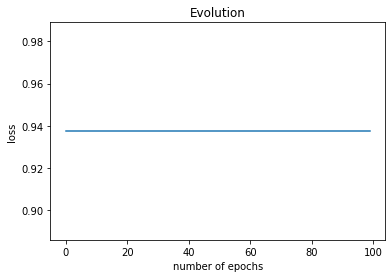

In [25]:
# neural network performances (loss stats)
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
# TODO: improve ylabel+title
ax.set(xlabel='number of epochs', ylabel='loss',
       title='Evolution')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

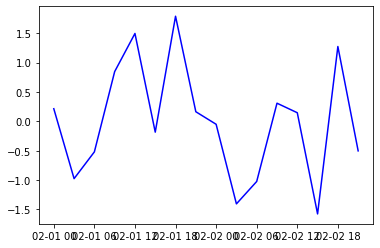

In [26]:
# results
# gca = get current axis
ax = plt.gca()
# dataset values
# TODO: remove label='Consommaation' ?
# TODO: specify title
plt.plot(data_train['Date - Heure'].values, target_data.values, '-', label='True data', color='b')
plt.plot(data_train['Date - Heure'].values, output.values, '--', label='Predictions', color='r')
plt.show()

# prediction results
# TODO: plot prediction results